# 🌦️ Analyse Météo – Notebook complet

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_parquet('../data/refined/weather.parquet')
df.head()

,date,city,temperature_c,humidity,wind_kmh,precip_mm,is_storm
0,2027-01-31,Lyon,8.7,31.0,13.0,0.9,0
1,2027-12-30,Marseille,15.2,87.8,38.9,4.5,0
2,2026-05-10,Toulouse,24.6,52.6,59.1,2.4,0
3,2027-07-18,Lyon,4.7,66.2,69.3,3.2,0
4,2027-02-04,Nice,6.4,34.8,50.1,1.2,0


##  Distributions

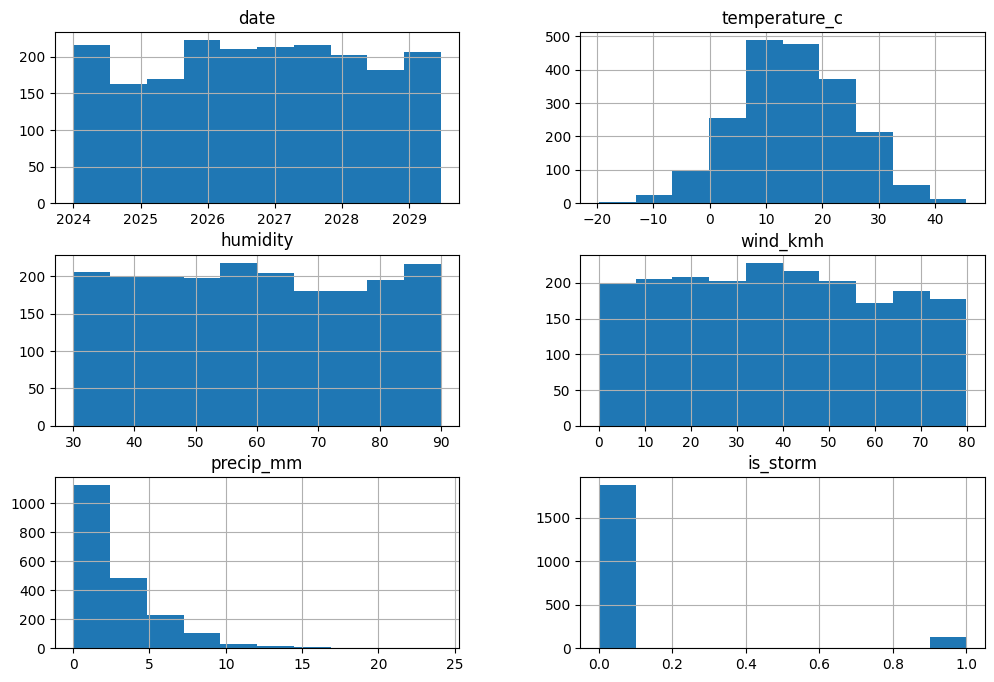

In [2]:
df.hist(figsize=(12,8))
plt.show()

##  Corrélations

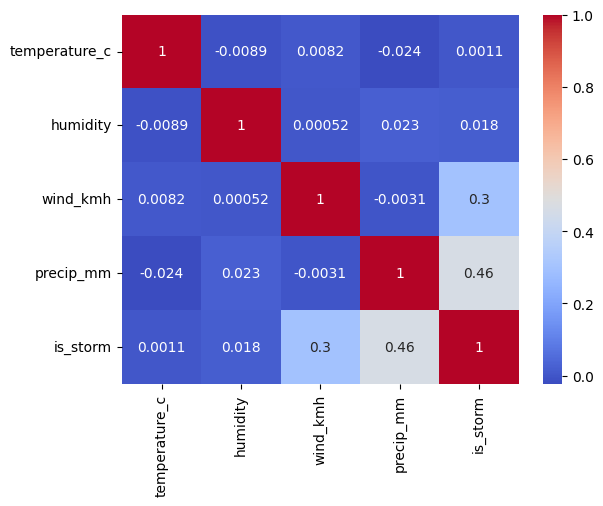

In [3]:
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.show()